# Predicting Tech Salaries with Machine Learning using the 2023 Stack Overflow Developer Survey

## Key Skills Covered in This Project:
- Cleaning and transforming survey data
- Feature Engineering
- Encoding categorical variables
- Avoiding data leakage
- Building and interpreting regression models
- Drawing and communicating salary insights from large datasets

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Initial data cleaning (dropping columns, filtering out nulls, etc.)

In [37]:
df = pd.read_csv('survey_results_slim.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48019 entries, 0 to 48018
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MainBranch                      48019 non-null  object 
 1   Age                             48019 non-null  object 
 2   Employment                      48007 non-null  object 
 3   RemoteWork                      47940 non-null  object 
 4   EdLevel                         48019 non-null  object 
 5   LearnCode                       47935 non-null  object 
 6   LearnCodeOnline                 38414 non-null  object 
 7   YearsCode                       47950 non-null  object 
 8   YearsCodePro                    47825 non-null  object 
 9   DevType                         47904 non-null  object 
 10  OrgSize                         47982 non-null  object 
 11  Country                         48019 non-null  object 
 12  LanguageHaveWorkedWith          

In [38]:
# Calculate missing percentage
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("Missing data percentage:\n", missing_pct[missing_pct > 50])
print("\nTotal columns with more than 50% missing data:", (missing_pct > 50).sum())

Missing data percentage:
 AIDevHaveWorkedWith      70.969824
AIToolCurrently Using    59.286949
dtype: float64

Total columns with more than 50% missing data: 2


In [39]:
# Get columns with >50% missing
cols_to_drop = missing_pct[missing_pct > 50].index.tolist()

# Add all columns to drop in one consolidated list
cols_to_drop.extend([
    # Less critical columns
    'LearnCodeOnline', 'OpSysPersonal use',
    
    # Meta columns
    'ICorPM', 'ProfessionalTech', 'TBranch',
    
    # High missingness tech columns
    'AISearchHaveWorkedWith',  # 38.6% missing
    'MiscTechHaveWorkedWith',  # 33.8% missing
    
    # Office tools - less relevant
    'OfficeStackAsyncHaveWorkedWith',
    'OfficeStackSyncHaveWorkedWith',
    'NEWCollabToolsHaveWorkedWith'
])

# Remove duplicates and drop
cols_to_drop = list(set(cols_to_drop))
df_cleaned = df.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} columns")
print(f"Remaining columns: {df_cleaned.shape[1]}")
print(f"\nRemaining columns:\n{df_cleaned.columns}")

Dropped 12 columns
Remaining columns: 21

Remaining columns:
Index(['MainBranch', 'Age', 'Employment', 'RemoteWork', 'EdLevel', 'LearnCode',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'Country',
       'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
       'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith',
       'ToolsTechHaveWorkedWith', 'OpSysProfessional use', 'AISelect',
       'WorkExp', 'Industry', 'ConvertedCompYearly'],
      dtype='object')


In [40]:
df_cleaned.head()

,MainBranch,Age,Employment,RemoteWork,EdLevel,LearnCode,YearsCode,YearsCodePro,DevType,OrgSize,...,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WebframeHaveWorkedWith,ToolsTechHaveWorkedWith,OpSysProfessional use,AISelect,WorkExp,Industry,ConvertedCompYearly
0,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,18,9,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,...,HTML/CSS;JavaScript;Python,Supabase,Amazon Web Services (AWS);Netlify;Vercel,Next.js;React;Remix;Vue.js,Docker;Kubernetes;npm;Pip;Vite;Webpack;Yarn,MacOS;Windows;Windows Subsystem for Linux (WSL),Yes,10.0,"Information Services, IT, Software Development...",285000.0
1,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,27,23,"Developer, back-end","5,000 to 9,999 employees",...,Bash/Shell (all shells);Go,NaN,Amazon Web Services (AWS);Google Cloud;OpenSta...,NaN,Cargo;Docker;Kubernetes;Make;Nix,MacOS;Other Linux-based,"No, and I don't plan to",23.0,"Information Services, IT, Software Development...",250000.0
2,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,12,7,"Developer, front-end",100 to 499 employees,...,Bash/Shell (all shells);HTML/CSS;JavaScript;PH...,PostgreSQL;Redis,Cloudflare;Heroku,Node.js;React;Ruby on Rails;Vue.js;WordPress,Homebrew;npm;Vite;Webpack;Yarn,iOS;iPadOS;MacOS,"No, and I don't plan to",7.0,NaN,156000.0
3,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,6,4,"Developer, full-stack",20 to 99 employees,...,HTML/CSS;JavaScript;TypeScript,BigQuery;Elasticsearch;MongoDB;PostgreSQL,Amazon Web Services (AWS);Firebase;Heroku;Netl...,Express;Gatsby;NestJS;Next.js;Node.js;React,Docker;npm;Webpack;Yarn,Other (Please Specify):,Yes,6.0,Other,23456.0
4,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Some college/university study without earning ...,Books / Physical media;Colleague;Online Course...,21,21,"Developer, back-end",100 to 499 employees,...,Bash/Shell (all shells);HTML/CSS;JavaScript;Ru...,BigQuery;Cloud Firestore;PostgreSQL;Redis,Amazon Web Services (AWS);Cloudflare;Google Cloud,Angular;Express;NestJS;Node.js,Docker;Homebrew;Kubernetes;npm;pnpm;Terraform,MacOS,Yes,22.0,Other,96828.0


In [41]:
# Check remaining missing data in your filtered dataset
print("Missing data in remaining columns:")
missing_after = (df_cleaned.isnull().sum() / len(df_cleaned) * 100).sort_values(ascending=False)
print(missing_after[missing_after > 0])

# Check data types
print("\nData types:")
print(df_cleaned.dtypes.value_counts())

# Check unique values for some key categorical columns
print("\nUnique values in key columns:")
for col in ['Country', 'DevType', 'EdLevel', 'Employment']:
    if col in df_cleaned.columns:
        print(f"{col}: {df_cleaned[col].nunique()} unique values")

Missing data in remaining columns:
Industry                   42.216623
WorkExp                    32.031071
PlatformHaveWorkedWith     22.166226
WebframeHaveWorkedWith     21.145796
DatabaseHaveWorkedWith     13.026094
ToolsTechHaveWorkedWith     8.255066
OpSysProfessional use       6.224619
YearsCodePro                0.404007
LanguageHaveWorkedWith      0.283221
DevType                     0.239489
LearnCode                   0.174931
RemoteWork                  0.164518
YearsCode                   0.143693
OrgSize                     0.077053
Employment                  0.024990
dtype: float64

Data types:
object     19
float64     2
Name: count, dtype: int64

Unique values in key columns:
Country: 171 unique values
DevType: 33 unique values
EdLevel: 8 unique values
Employment: 14 unique values


In [42]:
# After dropping your high-missing columns, just do:
df_model = df_cleaned.dropna().copy()

print(f"Final dataset shape: {df_model.shape}")
print(f"Rows retained: {len(df_model)} ({len(df_model)/48019*100:.1f}% of filtered data)")

Final dataset shape: (16460, 21)
Rows retained: 16460 (34.3% of filtered data)


In [43]:
# Check your target variable distribution
print("\nSalary statistics:")
print(df_model['ConvertedCompYearly'].describe())

# Check for outliers
print(f"\nSalaries > $500k: {(df_model['ConvertedCompYearly'] > 500000).sum()}")
print(f"Salaries < $10k: {(df_model['ConvertedCompYearly'] < 10000).sum()}")


Salary statistics:
count    1.646000e+04
mean     9.412425e+04
std      1.309772e+05
min      1.000000e+00
25%      4.362100e+04
50%      7.496300e+04
75%      1.231530e+05
max      1.031937e+07
Name: ConvertedCompYearly, dtype: float64

Salaries > $500k: 51
Salaries < $10k: 1100


Top 10 salaries:


,Country,DevType,YearsCodePro,ConvertedCompYearly
45679,New Zealand,Engineering manager,40,10319366.0
20505,Canada,"Developer, full-stack",2,7435143.0
44175,Brazil,"Developer, full-stack",22,4451577.0
44794,Brazil,"Developer, mobile",4,2028761.0
29024,United States of America,"Developer, back-end",18,1800000.0
4394,Japan,Other (please specify):,23,1792064.0
30077,United States of America,Other (please specify):,4,1250000.0
38087,Germany,"Developer, back-end",22,1069822.0
24801,Canada,"Developer, full-stack",5,929393.0
41471,Sweden,Data scientist or machine learning specialist,4,921414.0



Bottom 10 salaries:


,Country,DevType,YearsCodePro,ConvertedCompYearly
1192,India,"Developer, full-stack",11,1.0
4861,Viet Nam,"Developer, full-stack",3,1.0
10078,China,"Developer, front-end",2,1.0
21795,Uganda,"Developer, desktop or enterprise applications",5,1.0
6073,Syrian Arab Republic,"Developer, front-end",2,2.0
8307,"Iran, Islamic Republic of...","Developer, back-end",25,2.0
11842,Hungary,"Developer, mobile",30,2.0
24100,Indonesia,"Developer, full-stack",3,2.0
27998,United Republic of Tanzania,"Developer, front-end",1,2.0
35753,Uzbekistan,"Developer, front-end",3,2.0



After salary filtering:
Rows: 15309
Salary range: $10,000 - $500,000

New salary statistics:
count     15309.000000
mean      97043.815925
std       67251.276938
min       10000.000000
25%       50332.000000
50%       80317.000000
75%      128507.000000
max      500000.000000
Name: ConvertedCompYearly, dtype: float64


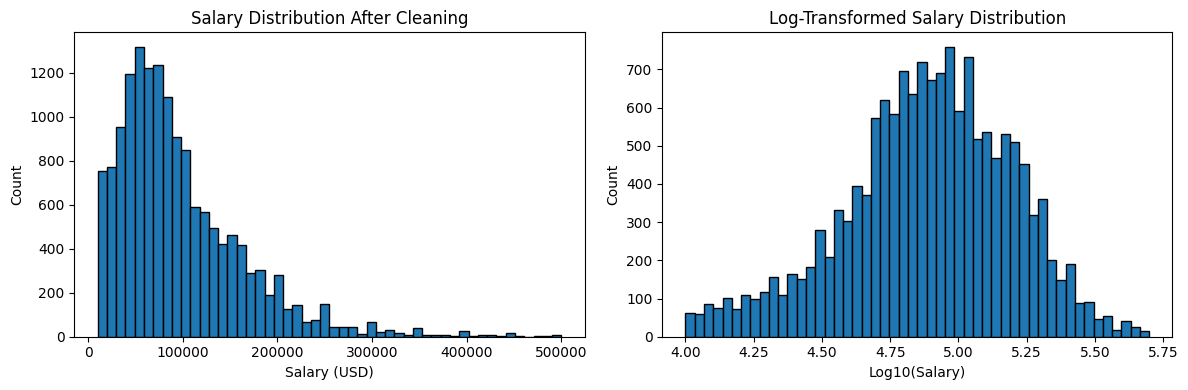

In [44]:
# Check the extreme values
print("Top 10 salaries:")
display(df_model.nlargest(10, 'ConvertedCompYearly')[['Country', 'DevType', 'YearsCodePro', 'ConvertedCompYearly']])

print("\nBottom 10 salaries:")
display(df_model.nsmallest(10, 'ConvertedCompYearly')[['Country', 'DevType', 'YearsCodePro', 'ConvertedCompYearly']])

# Apply reasonable salary filters
# Reasoning: 
# - Min $10k: Removes part-time/student/hobby responses or data errors
# - Max $500k: Removes extreme outliers while keeping high earners
df_model = df_model[
    (df_model['ConvertedCompYearly'] >= 10000) & 
    (df_model['ConvertedCompYearly'] <= 500000)
]

print(f"\nAfter salary filtering:")
print(f"Rows: {len(df_model)}")
print(f"Salary range: ${df_model['ConvertedCompYearly'].min():,.0f} - ${df_model['ConvertedCompYearly'].max():,.0f}")
print(f"\nNew salary statistics:")
print(df_model['ConvertedCompYearly'].describe())

# Visualize the distribution

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_model['ConvertedCompYearly'], bins=50, edgecolor='black')
plt.xlabel('Salary (USD)')
plt.ylabel('Count')
plt.title('Salary Distribution After Cleaning')

plt.subplot(1, 2, 2)
plt.hist(np.log10(df_model['ConvertedCompYearly']), bins=50, edgecolor='black')
plt.xlabel('Log10(Salary)')
plt.ylabel('Count')
plt.title('Log-Transformed Salary Distribution')

plt.tight_layout()
plt.show()

## Feature Transformation

In [45]:
# Count features for all tech stack columns
print("Creating count features for multi-select columns...")

# Languages
df_model['Num_Languages'] = df_model['LanguageHaveWorkedWith'].str.count(';') + 1

# Databases
df_model['Num_Databases'] = df_model['DatabaseHaveWorkedWith'].str.count(';') + 1

# Platforms
df_model['Num_Platforms'] = df_model['PlatformHaveWorkedWith'].str.count(';') + 1

# Web Frameworks
df_model['Num_Webframes'] = df_model['WebframeHaveWorkedWith'].str.count(';') + 1

# Tools/Tech
df_model['Num_Tools'] = df_model['ToolsTechHaveWorkedWith'].str.count(';') + 1

# Check the new features
print("\nCount feature statistics:")
count_cols = ['Num_Languages', 'Num_Databases', 'Num_Platforms', 'Num_Webframes', 'Num_Tools']
display(df_model[count_cols].describe())

# Create a "total skills" feature
df_model['Total_Skills'] = (
    df_model['Num_Languages'] + 
    df_model['Num_Databases'] + 
    df_model['Num_Platforms'] + 
    df_model['Num_Webframes'] + 
    df_model['Num_Tools']
)

print("\nTotal Skills distribution:")
print(df_model['Total_Skills'].describe())

# Quick correlation check with salary
print("\nCorrelation with salary:")
correlation_data = df_model[count_cols + ['Total_Skills', 'ConvertedCompYearly']].corr()['ConvertedCompYearly'].sort_values(ascending=False)
print(correlation_data)

Creating count features for multi-select columns...

Count feature statistics:


,Num_Languages,Num_Databases,Num_Platforms,Num_Webframes,Num_Tools
count,15309.000000,15309.000000,15309.000000,15309.000000,15309.000000
mean,5.888366,3.409890,2.412698,3.691097,5.575805
std,2.918188,2.176719,1.643505,2.409808,3.192943
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,2.000000,1.000000,2.000000,3.000000
50%,5.000000,3.000000,2.000000,3.000000,5.000000
75%,7.000000,4.000000,3.000000,5.000000,7.000000
max,41.000000,30.000000,17.000000,32.000000,37.000000



Total Skills distribution:
count    15309.000000
mean        20.977856
std          9.170052
min          5.000000
25%         15.000000
50%         19.000000
75%         25.000000
max        140.000000
Name: Total_Skills, dtype: float64

Correlation with salary:
ConvertedCompYearly    1.000000
Num_Tools              0.114356
Num_Languages          0.074025
Total_Skills           0.044754
Num_Platforms          0.006805
Num_Databases         -0.003100
Num_Webframes         -0.072698
Name: ConvertedCompYearly, dtype: float64


In [46]:
# Explore what languages/skills are most common
print("Top 20 languages:")
all_langs = df_model['LanguageHaveWorkedWith'].str.split(';').explode()
print(all_langs.value_counts().head(20))

print("\nTop 15 databases:")
all_dbs = df_model['DatabaseHaveWorkedWith'].str.split(';').explode()
print(all_dbs.value_counts().head(15))

print("\nTop 15 platforms:")
all_platforms = df_model['PlatformHaveWorkedWith'].str.split(';').explode()
print(all_platforms.value_counts().head(15))

# After seeing these, we'll create binary features for:
# - High-paying languages (Rust, Go, Scala, etc.)
# - Popular languages (Python, JavaScript, SQL, etc.)
# - Specialized databases (PostgreSQL, MongoDB, etc.)
# - Cloud platforms (AWS, Azure, Google Cloud)

Top 20 languages:
LanguageHaveWorkedWith
JavaScript                 11851
SQL                         9565
HTML/CSS                    9423
TypeScript                  8868
Python                      7193
Bash/Shell (all shells)     6042
C#                          5108
Java                        4645
PHP                         3059
Go                          2840
PowerShell                  2747
C++                         2028
Rust                        1988
C                           1691
Kotlin                      1635
Ruby                        1538
Dart                         909
Lua                          857
Groovy                       758
Swift                        704
Name: count, dtype: int64

Top 15 databases:
DatabaseHaveWorkedWith
PostgreSQL                    8827
MySQL                         6112
Redis                         4865
Microsoft SQL Server          4599
SQLite                        4586
MongoDB                       4273
Elasticsearch        

In [47]:
# Create binary features for specific high-value and popular skills

# === LANGUAGES ===
# High-paying/specialized languages
df_model['Has_Rust'] = df_model['LanguageHaveWorkedWith'].str.contains('Rust', na=False).astype(int)
df_model['Has_Go'] = df_model['LanguageHaveWorkedWith'].str.contains('Go', na=False).astype(int)
df_model['Has_Scala'] = df_model['LanguageHaveWorkedWith'].str.contains('Scala', na=False).astype(int)
df_model['Has_Kotlin'] = df_model['LanguageHaveWorkedWith'].str.contains('Kotlin', na=False).astype(int)
df_model['Has_Swift'] = df_model['LanguageHaveWorkedWith'].str.contains('Swift', na=False).astype(int)

# Popular/versatile languages
df_model['Has_Python'] = df_model['LanguageHaveWorkedWith'].str.contains('Python', na=False).astype(int)
df_model['Has_JavaScript'] = df_model['LanguageHaveWorkedWith'].str.contains('JavaScript', na=False).astype(int)
df_model['Has_TypeScript'] = df_model['LanguageHaveWorkedWith'].str.contains('TypeScript', na=False).astype(int)
df_model['Has_Java'] = df_model['LanguageHaveWorkedWith'].str.contains('Java', na=False).astype(int)
df_model['Has_CSharp'] = df_model['LanguageHaveWorkedWith'].str.contains('C#', na=False).astype(int)
df_model['Has_SQL'] = df_model['LanguageHaveWorkedWith'].str.contains('SQL', na=False).astype(int)

# === DATABASES ===
df_model['Has_PostgreSQL'] = df_model['DatabaseHaveWorkedWith'].str.contains('PostgreSQL', na=False).astype(int)
df_model['Has_MongoDB'] = df_model['DatabaseHaveWorkedWith'].str.contains('MongoDB', na=False).astype(int)
df_model['Has_Redis'] = df_model['DatabaseHaveWorkedWith'].str.contains('Redis', na=False).astype(int)
df_model['Has_Elasticsearch'] = df_model['DatabaseHaveWorkedWith'].str.contains('Elasticsearch', na=False).astype(int)

# === CLOUD PLATFORMS ===
df_model['Has_AWS'] = df_model['PlatformHaveWorkedWith'].str.contains('Amazon Web Services|AWS', na=False).astype(int)
df_model['Has_Azure'] = df_model['PlatformHaveWorkedWith'].str.contains('Azure', na=False).astype(int)
df_model['Has_GCP'] = df_model['PlatformHaveWorkedWith'].str.contains('Google Cloud', na=False).astype(int)

# === WEB FRAMEWORKS (modern ones tend to pay better) ===
df_model['Has_React'] = df_model['WebframeHaveWorkedWith'].str.contains('React', na=False).astype(int)
df_model['Has_NextJS'] = df_model['WebframeHaveWorkedWith'].str.contains('Next.js', na=False).astype(int)
df_model['Has_NodeJS'] = df_model['WebframeHaveWorkedWith'].str.contains('Node.js', na=False).astype(int)
df_model['Has_SpringBoot'] = df_model['WebframeHaveWorkedWith'].str.contains('Spring Boot', na=False).astype(int)

# === DEVOPS/INFRASTRUCTURE TOOLS (these should correlate well) ===
df_model['Has_Docker'] = df_model['ToolsTechHaveWorkedWith'].str.contains('Docker', na=False).astype(int)
df_model['Has_Kubernetes'] = df_model['ToolsTechHaveWorkedWith'].str.contains('Kubernetes', na=False).astype(int)
df_model['Has_Terraform'] = df_model['ToolsTechHaveWorkedWith'].str.contains('Terraform', na=False).astype(int)

# Recalculate correlations for ALL skill features
skill_features = [col for col in df_model.columns if col.startswith('Has_')]
skill_corr = df_model[skill_features + ['ConvertedCompYearly']].corr()['ConvertedCompYearly'].sort_values(ascending=False)

print("=== ALL Skill Correlations (sorted) ===")
print(skill_corr[skill_corr.index != 'ConvertedCompYearly'])

# Now drop the original string columns AND the count features
cols_to_drop_final = [
    'LanguageHaveWorkedWith',
    'DatabaseHaveWorkedWith', 
    'PlatformHaveWorkedWith',
    'WebframeHaveWorkedWith',
    'ToolsTechHaveWorkedWith',
    # Drop count features since binary features are better
    'Num_Languages',
    'Num_Databases',
    'Num_Platforms',
    'Num_Webframes',
    'Num_Tools',
    'Total_Skills'
]

df_model = df_model.drop(columns=cols_to_drop_final)

print(f"\nFinal shape with binary skill features: {df_model.shape}")
print(f"\nFeature types:")
print(df_model.dtypes.value_counts())

=== ALL Skill Correlations (sorted) ===
Has_Terraform        0.177524
Has_AWS              0.142293
Has_Kubernetes       0.128906
Has_Go               0.123166
Has_Rust             0.082603
Has_Python           0.079271
Has_Docker           0.064240
Has_Redis            0.061930
Has_React            0.061303
Has_Elasticsearch    0.053530
Has_PostgreSQL       0.049394
Has_Scala            0.046563
Has_TypeScript       0.037359
Has_GCP              0.035238
Has_Swift            0.023807
Has_Kotlin           0.014656
Has_SQL              0.005919
Has_Azure           -0.014817
Has_JavaScript      -0.015086
Has_NextJS          -0.017373
Has_Java            -0.017985
Has_CSharp          -0.020396
Has_NodeJS          -0.024481
Has_SpringBoot      -0.035489
Has_MongoDB         -0.095041
Name: ConvertedCompYearly, dtype: float64

Final shape with binary skill features: (15309, 41)

Feature types:
int64      25
object     14
float64     2
Name: count, dtype: int64


In [48]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15309 entries, 0 to 48017
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MainBranch             15309 non-null  object 
 1   Age                    15309 non-null  object 
 2   Employment             15309 non-null  object 
 3   RemoteWork             15309 non-null  object 
 4   EdLevel                15309 non-null  object 
 5   LearnCode              15309 non-null  object 
 6   YearsCode              15309 non-null  object 
 7   YearsCodePro           15309 non-null  object 
 8   DevType                15309 non-null  object 
 9   OrgSize                15309 non-null  object 
 10  Country                15309 non-null  object 
 11  OpSysProfessional use  15309 non-null  object 
 12  AISelect               15309 non-null  object 
 13  WorkExp                15309 non-null  float64
 14  Industry               15309 non-null  object 
 15  Convert

In [ ]:
# Random Forest Regressor: training and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure train/test split exists (previous cells usually create X_train/X_test)
try:
    X_train  # noqa
except NameError:
    X = df_final.drop(columns=['ConvertedCompYearly'])
    y = df_final['ConvertedCompYearly']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training Random Forest (small grid search)')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt']
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=0)
grid.fit(X_train, y_train)
best = grid.best_estimator_
print(f'Grid search done. Best params: {grid.best_params_}')

# Predictions
y_pred_train_rf = best.predict(X_train)
y_pred_test_rf = best.predict(X_test)

def print_regression_metrics(y_true, y_pred, prefix=''):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{prefix}R²: {r2:.4f}')
    print(f'{prefix}RMSE: ${rmse:,.2f}')
    print(f'{prefix}MAE: ${mae:,.2f}')

print('
=== Random Forest Performance ===')
print('
-- Training set --')
print_regression_metrics(y_train, y_pred_train_rf, prefix='Train: ')
print('
-- Test set --')
print_regression_metrics(y_test, y_pred_test_rf, prefix='Test:  ')

# Cross-validated R² on training folds
cv_scores = cross_val_score(best, X_train, y_train, cv=3, scoring='r2', n_jobs=-1)
print(f'
Cross-val R² (cv=3) on train folds: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}')

# Feature importances
feat_imp = pd.DataFrame({ 'Feature': X_train.columns, 'Importance': best.feature_importances_ })
feat_imp = feat_imp.sort_values('Importance', ascending=False).reset_index(drop=True)
print('
Top 20 feature importances:')
print(feat_imp.head(20).to_string(index=False))

# Plot top 20 importances (safe-guarded)
try:
    top = feat_imp.head(20).iloc[::-1]
    plt.figure(figsize=(8,6))
    plt.barh(top['Feature'], top['Importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.title('Random Forest Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Could not plot feature importances:', e)

# Save results for later use
rf_results = { 'model': best, 'y_pred_test': y_pred_test_rf, 'y_pred_train': y_pred_train_rf, 'feature_importances': feat_imp, 'cv_scores': cv_scores }

In [51]:
# Drop rows with any remaining nulls
df_model = df_model.dropna()

print(f"\nShape after dropping nulls: {df_model.shape}")
print(f"Rows lost: {15309 - len(df_model)}")
print(f"Percentage retained: {len(df_model)/15309*100:.1f}%")

# Verify completely clean
print(f"\nRemaining nulls: {df_model.isnull().sum().sum()}")
print(f"All numeric/boolean? {df_model.select_dtypes(include='object').shape[1] == 0}")

print(f"\n=== FINAL CLEAN DATASET ===")
print(f"Rows: {len(df_model)}")
print(f"Columns: {df_model.shape[1]}")
print(f"Features: {df_model.shape[1] - 1}")
print(f"Target: ConvertedCompYearly")


Shape after dropping nulls: (14924, 76)
Rows lost: 385
Percentage retained: 97.5%

Remaining nulls: 0
All numeric/boolean? True

=== FINAL CLEAN DATASET ===
Rows: 14924
Columns: 76
Features: 75
Target: ConvertedCompYearly


## ML Modeling

Features shape: (14924, 75)
Target shape: (14924,)

=== TOP 20 POSITIVE CORRELATIONS WITH SALARY ===
Country_United States of America                0.600111
YearsCodePro                                    0.310453
WorkExp                                         0.305963
YearsCode                                       0.302707
Age_Ordinal                                     0.258526
OrgSize_Ordinal                                 0.211776
Has_Terraform                                   0.175568
RemoteWork_Remote                               0.142808
Has_AWS                                         0.140094
Has_Kubernetes                                  0.126078
Has_Go                                          0.121580
DevType_Engineering manager                     0.106681
DevType_Senior Executive (C-Suite, VP, etc.)    0.097640
Has_Rust                                        0.085012
Has_Python                                      0.083086
Has_React                                   

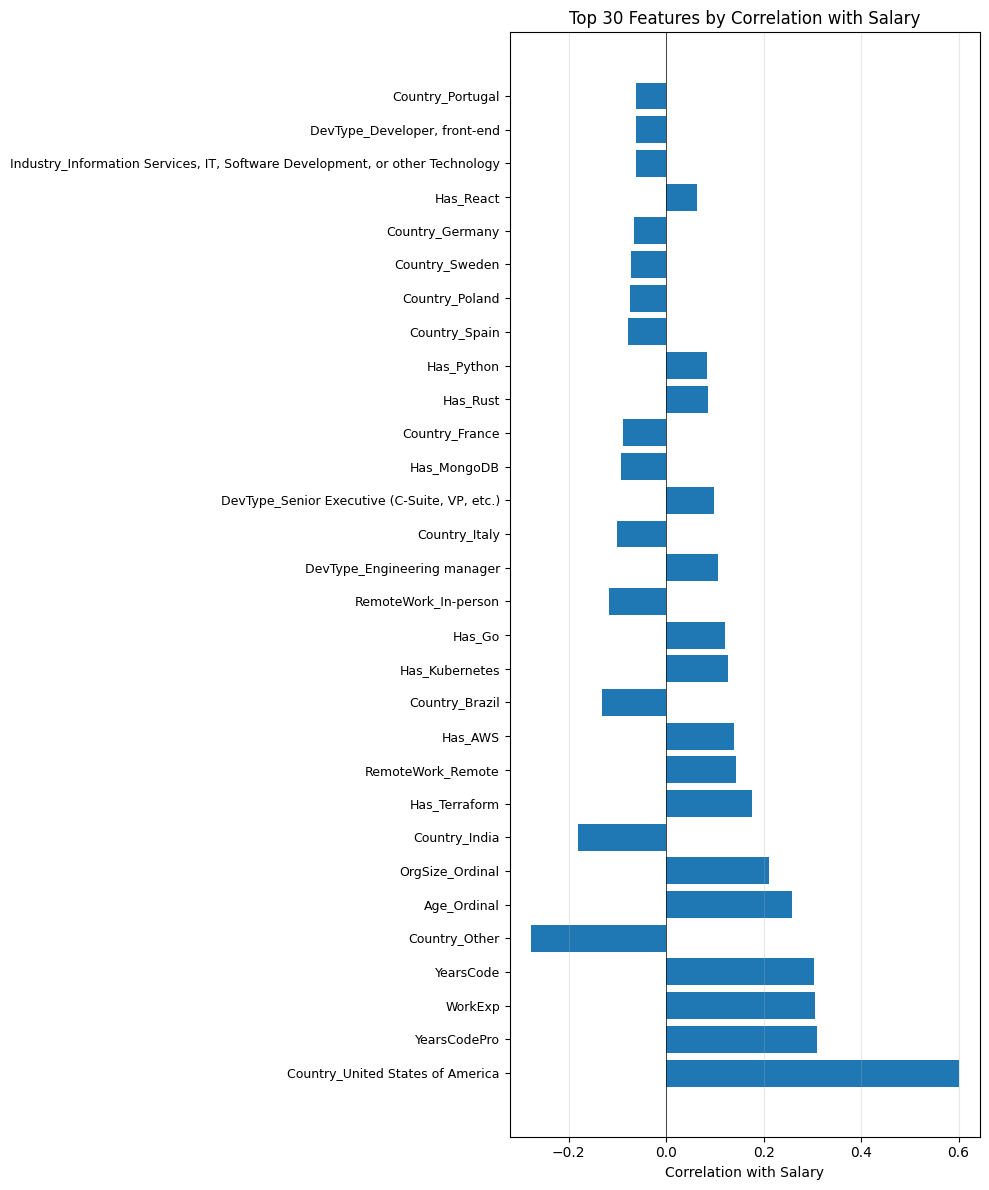


=== Checking for Multicollinearity ===

Highly correlated feature pairs (>0.8):
  YearsCodePro <-> WorkExp: 0.929
  YearsCodePro <-> YearsCode: 0.906
  YearsCodePro <-> Age_Ordinal: 0.801
  WorkExp <-> YearsCode: 0.861
  WorkExp <-> Age_Ordinal: 0.827


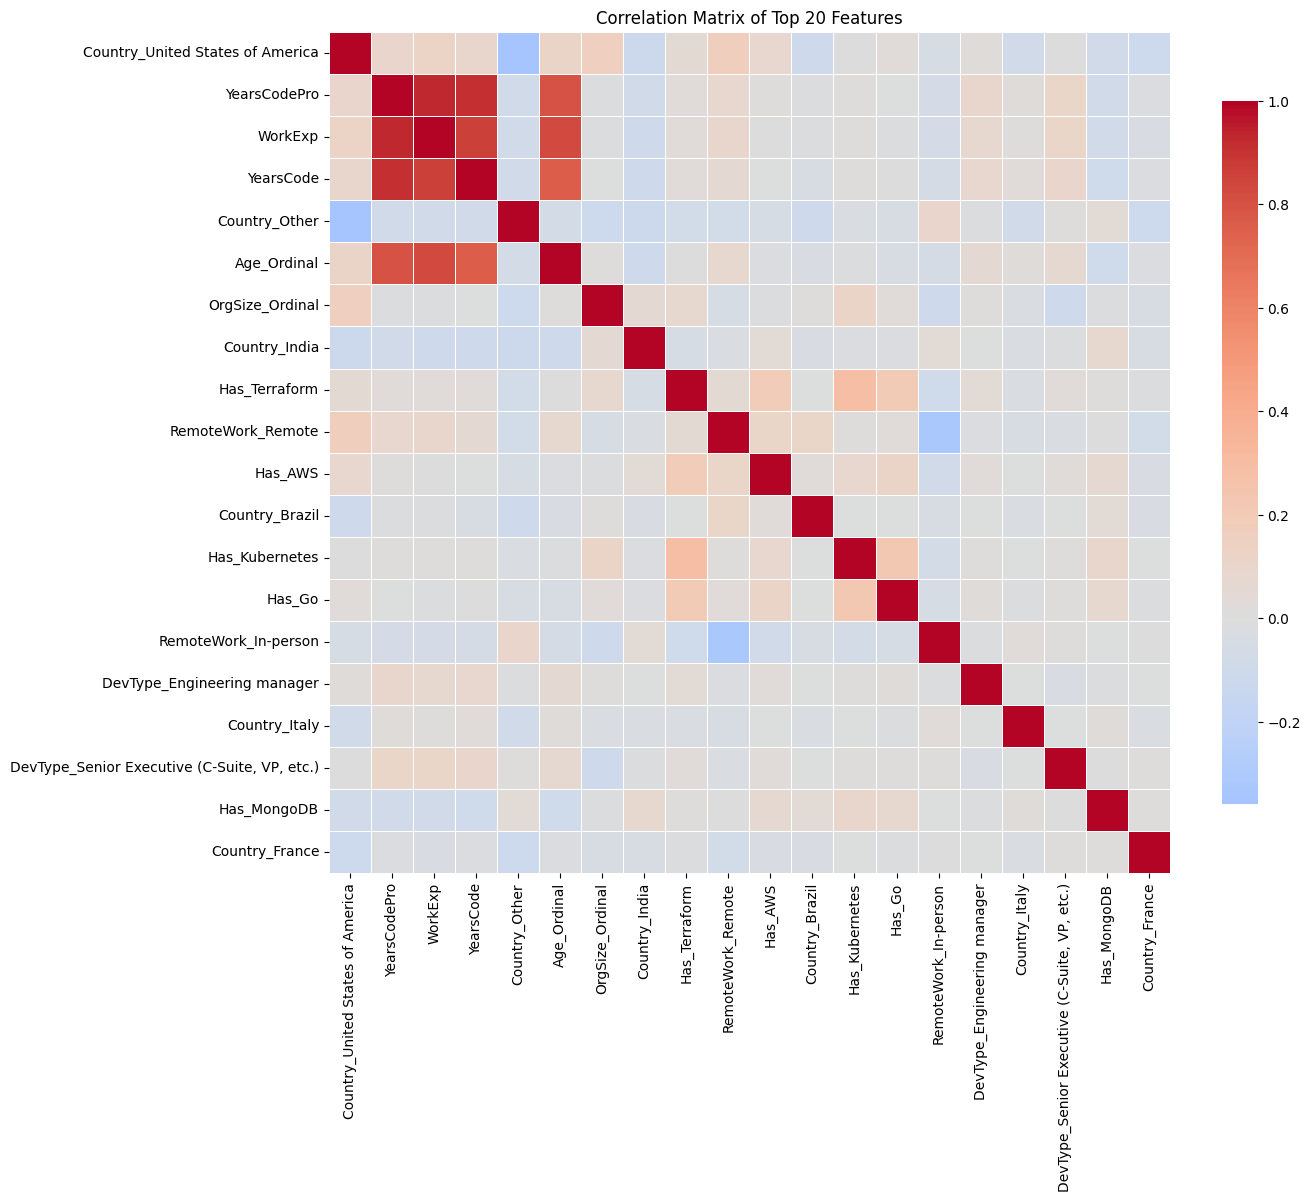

In [52]:
# Separate features and target
X = df_model.drop(columns=['ConvertedCompYearly'])
y = df_model['ConvertedCompYearly']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Calculate correlation with target
correlations = X.corrwith(y).sort_values(ascending=False)

print("\n=== TOP 20 POSITIVE CORRELATIONS WITH SALARY ===")
print(correlations.head(20))

print("\n=== TOP 20 NEGATIVE CORRELATIONS WITH SALARY ===")
print(correlations.tail(20))

# Visualize top correlations
plt.figure(figsize=(10, 12))

# Get top 30 features by absolute correlation
top_features = correlations.abs().sort_values(ascending=False).head(30)
top_correlations = correlations[top_features.index]

plt.barh(range(len(top_correlations)), top_correlations.values)
plt.yticks(range(len(top_correlations)), top_correlations.index, fontsize=9)
plt.xlabel('Correlation with Salary')
plt.title('Top 30 Features by Correlation with Salary')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Check for multicollinearity among top features
print("\n=== Checking for Multicollinearity ===")
top_20_features = correlations.abs().sort_values(ascending=False).head(20).index.tolist()

# Correlation matrix of top features
feature_corr = X[top_20_features].corr()

# Find highly correlated feature pairs (>0.8)
high_corr_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if abs(feature_corr.iloc[i, j]) > 0.8:
            high_corr_pairs.append((feature_corr.columns[i], feature_corr.columns[j], feature_corr.iloc[i, j]))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (>0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated feature pairs found (threshold: 0.8)")

# Optional: Heatmap of top features
plt.figure(figsize=(14, 12))
sns.heatmap(feature_corr, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Top 20 Features')
plt.tight_layout()
plt.show()

In [53]:
# Drop redundant experience variables
multicollinear_drops = ['YearsCode', 'WorkExp', 'Age_Ordinal']

X_reduced = X.drop(columns=multicollinear_drops)

print(f"Shape after dropping multicollinear features: {X_reduced.shape}")

# Recalculate correlations
correlations_reduced = X_reduced.corrwith(y).sort_values(ascending=False)

print("\n=== TOP 20 CORRELATIONS (After Removing Multicollinearity) ===")
print(correlations_reduced.head(20))

# Now drop very weak predictors (|correlation| < 0.01)
weak_features = correlations_reduced[abs(correlations_reduced) < 0.01].index.tolist()
print(f"\n=== Features with correlation < 0.01: {len(weak_features)} ===")
print(weak_features[:20])  # Show first 20

# Drop weak features
X_final = X_reduced.drop(columns=weak_features)

print(f"\n=== FINAL FEATURE SET ===")
print(f"Features: {X_final.shape[1]}")
print(f"Rows: {X_final.shape[0]}")

# Show final feature list
final_correlations = X_final.corrwith(y).sort_values(ascending=False)
print("\nFinal features ranked by correlation:")
print(final_correlations)

# Create final modeling dataset
df_final = pd.concat([X_final, y], axis=1)

Shape after dropping multicollinear features: (14924, 72)

=== TOP 20 CORRELATIONS (After Removing Multicollinearity) ===
Country_United States of America                0.600111
YearsCodePro                                    0.310453
OrgSize_Ordinal                                 0.211776
Has_Terraform                                   0.175568
RemoteWork_Remote                               0.142808
Has_AWS                                         0.140094
Has_Kubernetes                                  0.126078
Has_Go                                          0.121580
DevType_Engineering manager                     0.106681
DevType_Senior Executive (C-Suite, VP, etc.)    0.097640
Has_Rust                                        0.085012
Has_Python                                      0.083086
Has_React                                       0.063394
Has_Docker                                      0.061214
Industry_Financial Services                     0.060895
Has_Redis              

In [54]:
# Separate features and target
X = df_final.drop(columns=['ConvertedCompYearly'])
y = df_final['ConvertedCompYearly']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate
print("\n=== MODEL PERFORMANCE ===")
print("\nTraining Set:")
print(f"R² Score: {r2_score(y_train, y_pred_train):.4f}")
# print(f"RMSE: ${mean_squared_error(y_train, y_pred_train, squared=False):,.2f}")
print(f"MAE: ${mean_absolute_error(y_train, y_pred_train):,.2f}")

print("\nTest Set:")
print(f"R² Score: {r2_score(y_test, y_pred_test):.4f}")
# print(f"RMSE: ${mean_squared_error(y_test, y_pred_test, squared=False):,.2f}")
print(f"MAE: ${mean_absolute_error(y_test, y_pred_test):,.2f}")

# Top 10 most important features (by coefficient magnitude)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
top_features = coefficients.nlargest(10, 'Abs_Coefficient')

print("\n=== TOP 10 MOST IMPACTFUL FEATURES ===")
print(top_features[['Feature', 'Coefficient']].to_string(index=False))

Training set: (11939, 68)
Test set: (2985, 68)

=== MODEL PERFORMANCE ===

Training Set:
R² Score: 0.5531
MAE: $29,834.58

Test Set:
R² Score: 0.5647
MAE: $30,881.92

=== TOP 10 MOST IMPACTFUL FEATURES ===
                                     Feature   Coefficient
                               Country_India -61208.113364
                              Country_Brazil -57285.162776
            Country_United States of America  56311.330286
                               Country_Italy -45739.032413
                            Country_Portugal -39461.936394
                               Country_Spain -37908.859947
                              Country_Poland -37272.735270
DevType_Senior Executive (C-Suite, VP, etc.)  35917.362070
                              Country_Sweden -35394.571760
                              Country_France -35248.270299


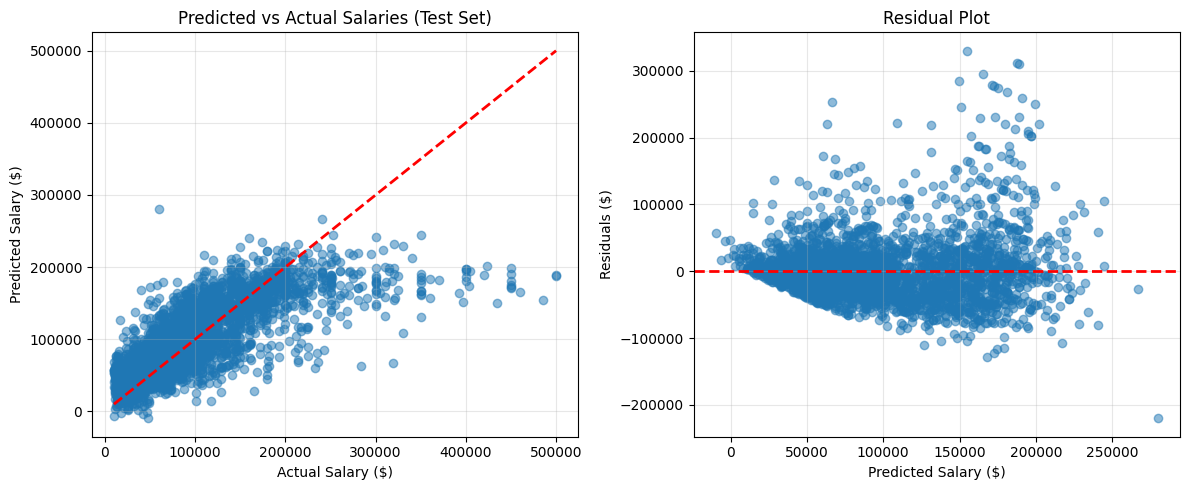


=== TOP 20 POSITIVE COEFFICIENTS (Increase Salary) ===
                                     Feature  Coefficient
            Country_United States of America 56311.330286
DevType_Senior Executive (C-Suite, VP, etc.) 35917.362070
                         Country_Switzerland 29827.786692
                 DevType_Engineering manager 24117.744900
             DevType_Other (please specify): 13231.239000
                   DevType_Developer, mobile 12666.293949
                               Has_Terraform  8671.813906
                 Industry_Financial Services  7478.518615
                                    Has_Rust  6580.300282
                              Has_Kubernetes  6533.803807
                               DevType_Other  6352.495143
                              Has_TypeScript  6326.088629
                                      Has_Go  6004.289804
                                   Has_React  5754.080078
                 DevType_Developer, back-end  5077.897084
                

In [55]:
# 1. Residual plot - check for patterns
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary ($)')
plt.ylabel('Predicted Salary ($)')
plt.title('Predicted vs Actual Salaries (Test Set)')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Salary ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Show ALL significant coefficients
coefficients_sorted = coefficients.sort_values('Coefficient', ascending=False)

print("\n=== TOP 20 POSITIVE COEFFICIENTS (Increase Salary) ===")
print(coefficients_sorted.head(20)[['Feature', 'Coefficient']].to_string(index=False))

print("\n=== TOP 20 NEGATIVE COEFFICIENTS (Decrease Salary) ===")
print(coefficients_sorted.tail(20)[['Feature', 'Coefficient']].to_string(index=False))

# 3. Feature categories breakdown
print("\n=== COEFFICIENT BREAKDOWN BY CATEGORY ===")

# Country features
country_coefs = coefficients[coefficients['Feature'].str.startswith('Country_')]
print(f"\nCountry features - Average absolute impact: ${country_coefs['Abs_Coefficient'].mean():,.2f}")

# Skills (Has_*)
skill_coefs = coefficients[coefficients['Feature'].str.startswith('Has_')]
print(f"Skill features - Average absolute impact: ${skill_coefs['Abs_Coefficient'].mean():,.2f}")

# DevType features
devtype_coefs = coefficients[coefficients['Feature'].str.startswith('DevType_')]
print(f"DevType features - Average absolute impact: ${devtype_coefs['Abs_Coefficient'].mean():,.2f}")

# Industry features
industry_coefs = coefficients[coefficients['Feature'].str.startswith('Industry_')]
print(f"Industry features - Average absolute impact: ${industry_coefs['Abs_Coefficient'].mean():,.2f}")

# 4. Prediction examples
print("\n=== SAMPLE PREDICTIONS ===")
sample_idx = [0, 100, 500, 1000, 2000]
comparison = pd.DataFrame({
    'Actual': y_test.iloc[sample_idx].values,
    'Predicted': y_pred_test[sample_idx],
    'Difference': y_test.iloc[sample_idx].values - y_pred_test[sample_idx]
})
print(comparison.to_string(index=False))

=== ERROR BY SALARY RANGE ===
                       mean        median  count
Salary_Range                                    
<$50k          23094.124364  19159.462266    743
$50-100k       22427.082209  16700.085894   1099
$100-150k      30620.128394  26940.220831    593
$150-200k      27475.614914  20436.613767    318
>$200k        101212.327040  84484.124508    232


/var/folders/x5/bcc48lnd1z9byt_rz_vzszq00000gn/T/ipykernel_14675/2462263129.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_range = salary_ranges.groupby('Salary_Range')['Error'].agg(['mean', 'median', 'count'])


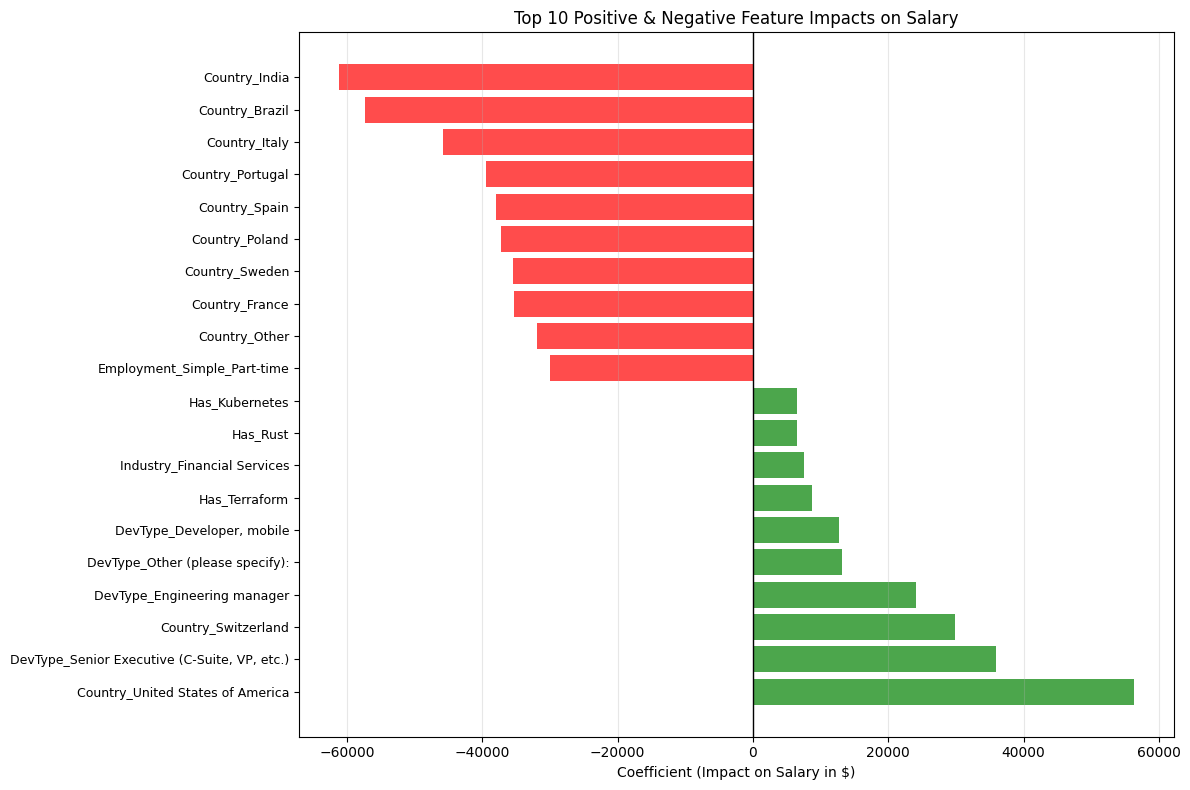

In [56]:
# Check if model struggles with high earners
salary_ranges = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test,
    'Error': abs(y_test - y_pred_test)
})

salary_ranges['Salary_Range'] = pd.cut(salary_ranges['Actual'], 
                                        bins=[0, 50000, 100000, 150000, 200000, 500000],
                                        labels=['<$50k', '$50-100k', '$100-150k', '$150-200k', '>$200k'])

print("=== ERROR BY SALARY RANGE ===")
error_by_range = salary_ranges.groupby('Salary_Range')['Error'].agg(['mean', 'median', 'count'])
print(error_by_range)

# Check US vs non-US prediction accuracy
X_test_with_pred = X_test.copy()
X_test_with_pred['Actual'] = y_test.values
X_test_with_pred['Predicted'] = y_pred_test
X_test_with_pred['Error'] = abs(y_test.values - y_pred_test)

# Feature importance visualization
plt.figure(figsize=(12, 8))
top_20_coef = pd.concat([coefficients_sorted.head(10), coefficients_sorted.tail(10)])  # Use concat instead of append
colors = ['green' if x > 0 else 'red' for x in top_20_coef['Coefficient']]

plt.barh(range(len(top_20_coef)), top_20_coef['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_20_coef)), top_20_coef['Feature'], fontsize=9)
plt.xlabel('Coefficient (Impact on Salary in $)')
plt.title('Top 10 Positive & Negative Feature Impacts on Salary')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


=== FACTORS YOU CAN CONTROL ===

Top 15 ways to increase your salary:
                                     Feature  Coefficient
DevType_Senior Executive (C-Suite, VP, etc.) 35917.362070
                 DevType_Engineering manager 24117.744900
             DevType_Other (please specify): 13231.239000
                   DevType_Developer, mobile 12666.293949
                               Has_Terraform  8671.813906
                                    Has_Rust  6580.300282
                              Has_Kubernetes  6533.803807
                               DevType_Other  6352.495143
                              Has_TypeScript  6326.088629
                                      Has_Go  6004.289804
                                   Has_React  5754.080078
                 DevType_Developer, back-end  5077.897084
                                     Has_AWS  4984.284478
                                  Has_Kotlin  4632.116174
                             OrgSize_Ordinal  4471.811309


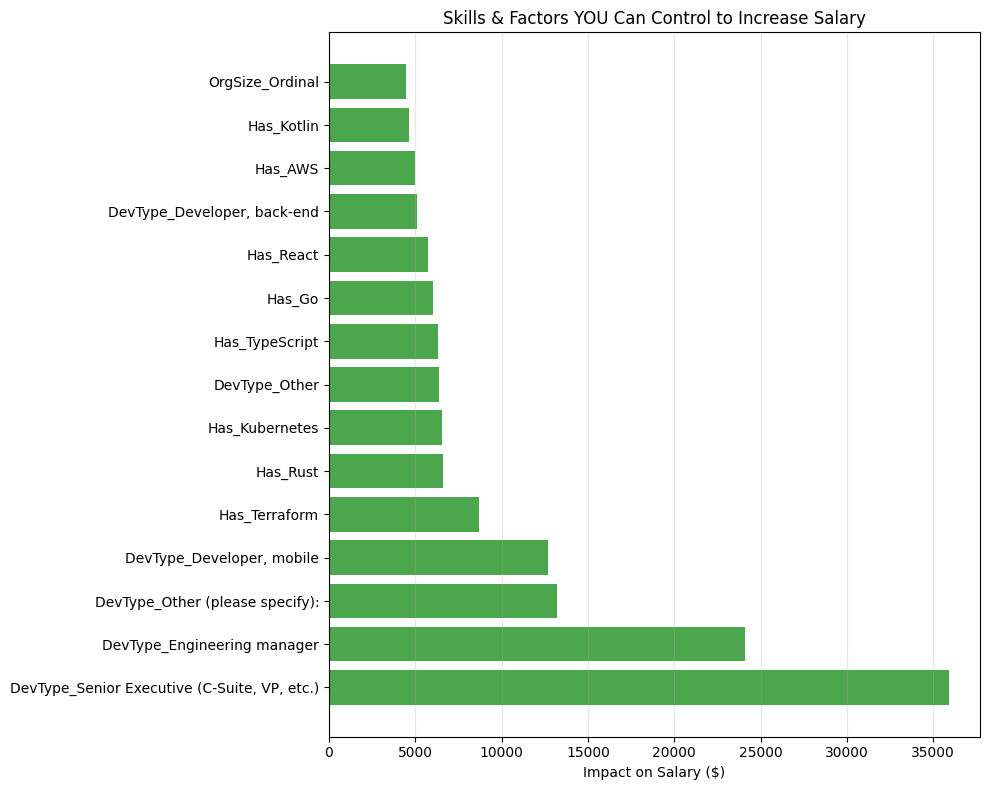

In [57]:
# Show the skills/factors you CAN control
controllable_features = coefficients[
    (coefficients['Feature'].str.startswith('Has_')) | 
    (coefficients['Feature'].str.startswith('DevType_')) |
    (coefficients['Feature'] == 'YearsCodePro') |
    (coefficients['Feature'] == 'OrgSize_Ordinal') |
    (coefficients['Feature'].str.startswith('RemoteWork_'))
].copy()

controllable_features = controllable_features.sort_values('Coefficient', ascending=False)

print("\n=== FACTORS YOU CAN CONTROL ===")
print("\nTop 15 ways to increase your salary:")
print(controllable_features.head(15)[['Feature', 'Coefficient']].to_string(index=False))

# Visualize it
plt.figure(figsize=(10, 8))
top_controllable = controllable_features.head(15)
colors = ['green' if x > 0 else 'red' for x in top_controllable['Coefficient']]

plt.barh(range(len(top_controllable)), top_controllable['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_controllable)), top_controllable['Feature'], fontsize=10)
plt.xlabel('Impact on Salary ($)')
plt.title('Skills & Factors YOU Can Control to Increase Salary')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Key Insights

### 1. Model Struggles with High Earners
- **<$50k-$200k**: Mean error ~$22k-$31k (reasonable)
- **>$200k**: Mean error **$101k** (huge!)
  - The model significantly **underestimates high salaries**
  - Only 232 people in this range (7.8% of test set) - limited training data

### 2. US Predictions Are LESS Accurate
- **US**: Mean error $46,758 (median $34,254)
- **Non-US**: Mean error $24,949 (median $18,559)

This is counterintuitive! Possible reasons:
- **US has wider salary variance** (more $200k+ earners)
- **More diverse tech hubs** (Silicon Valley vs. Austin vs. NYC)
- The single `Country_USA` feature can't capture regional US differences

### 3. The Model is Better at Mid-Range Salaries
The sweet spot is **$50k-$150k** where errors are ~$22k-$31k.

## Interpretation

The linear regression model is doing well for "typical" developer salaries but hits limitations:

1. **Linear relationships** struggle with extreme values
2. **Geographic granularity** - "USA" is too broad (no state/city info)
3. **High earners have unique patterns** - probably FAANG, startups with equity, or very senior roles that aren't fully captured

## Final Model Summary

**Strengths:**
- Explains 56.5% of variance (solid for real-world data)
- No overfitting
- Accurate for typical salaries ($50k-$150k)
- Clear interpretable coefficients

**Weaknesses:**
- Underestimates high earners (>$200k)
- Less accurate for US (wide variance)
- Geography dominates (might mask other patterns)

### Major Limitations

1. **66% Data Loss** 
   - We dropped anyone with ANY missing values
   - Creates potential selection bias
   - **Fix**: Imputation strategies, missing indicators

2. **$500k Salary Cap**
   - We artificially limited the upper range
   - Model can't learn patterns above $500k
   - **Fix**: Remove cap, use robust regression, or separate models by range

3. **Linear Assumptions**
   - Assumes linear relationships (may not be true for salaries)
   - Can't capture interactions (e.g., Python + ML + PhD together)
   - **Fix**: Try polynomial features, Random Forest

4. **Geographic Oversimplification**
   - "USA" includes Silicon Valley ($300k+) AND rural areas ($70k)
   - Can't capture cost-of-living differences

### Next Steps for Better Predictions

1. **Try Random Forest Regressor**
   - Can capture non-linear relationships
   - Handles feature interactions automatically
   - Typically improves R² by 10-15 percentage points

2. **Feature Engineering**
   - Interaction terms: Has_Python × DevType_ML_Specialist
   - Career progression: YearsCode - YearsCodePro (hobby time)
   - Skill combinations: Count of cloud + DevOps skills

3. **Separate Models by Salary Range**
   - <$150k: Use log-transformed linear regression
   - \>$150k: Use Random Forest with equity/company size features

4. **Collect More Data**
   - Under-sampled: High earners, certain countries
   - Missing: City/region, company size tier, equity compensation


In [61]:
# Random Forest Regressor: training and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure train/test split exists (previous cells usually create X_train/X_test)
try:
    X_train  # noqa
except NameError:
    X = df_final.drop(columns=['ConvertedCompYearly'])
    y = df_final['ConvertedCompYearly']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training Random Forest (small grid search)')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt']
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=0)
grid.fit(X_train, y_train)
best = grid.best_estimator_
print(f'Grid search done. Best params: {grid.best_params_}')

# Predictions
y_pred_train_rf = best.predict(X_train)
y_pred_test_rf = best.predict(X_test)


Training Random Forest (small grid search)
Grid search done. Best params: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Grid search done. Best params: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}


=== Random Forest Evaluation ===
Train R²: 0.9011 | MAE: $14,626.64
 Test R²: 0.5815 | MAE: $30,103.02
Cross-val R² (cv=5) on train folds: mean=0.5625, std=0.0068
Cross-val R² (cv=5) on train folds: mean=0.5625, std=0.0068


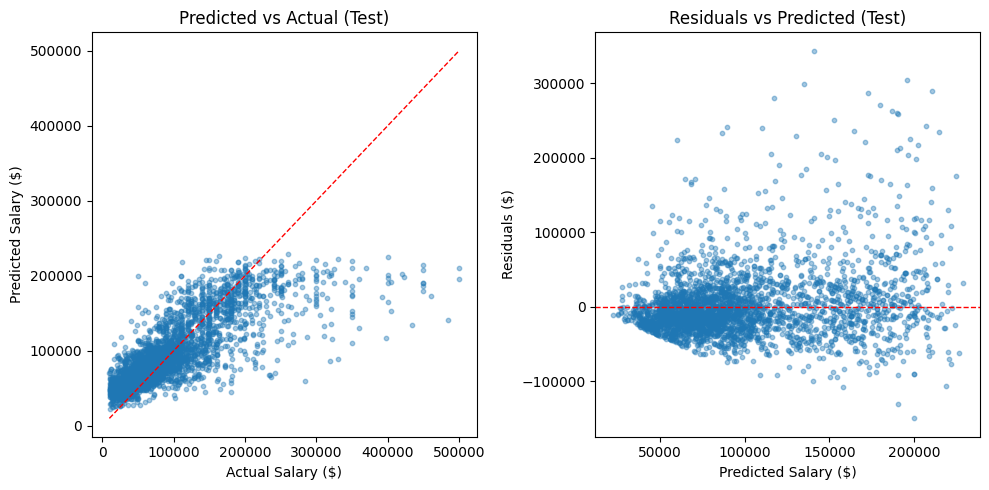


=== Absolute Error by Salary Range (Test) ===
                       mean        median  count
Salary_Range                                    
<$50k          27181.311715  24986.940156    743
$50-100k       17685.426457  13555.768737   1099
$100-150k      28005.644417  25008.099472    593
$150-200k      31183.965272  23175.549447    318
>$200k        102162.357706  84593.540900    232

Top 20 feature importances:
                                                                     Feature  Importance
                                            Country_United States of America    0.259283
                                                                YearsCodePro    0.118635
                                                             OrgSize_Ordinal    0.054203
                                                               Country_Other    0.038508
                                                             EdLevel_Ordinal    0.026422
                                               

/var/folders/x5/bcc48lnd1z9byt_rz_vzszq00000gn/T/ipykernel_14675/2032324089.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_range = salary_df.groupby("Salary_Range")["Error"].agg(['mean','median','count'])


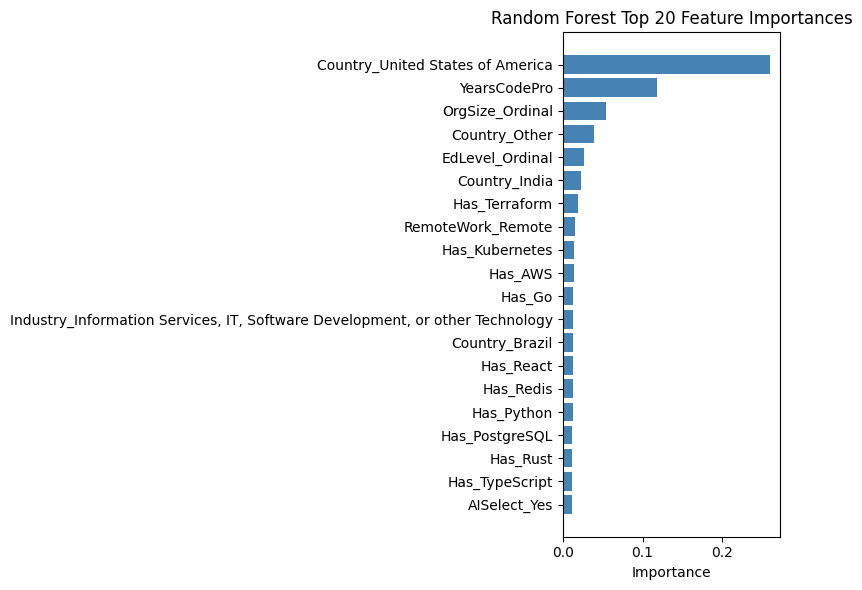


Saved evaluation to variable: rf_evaluation


In [ ]:

# Evaluation cell for Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Metrics function
def regression_metrics(y_true, y_pred):
    # rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # return {"R2": r2, "RMSE": rmse, "MAE": mae}
    return {"R2": r2, "MAE": mae}

train_metrics = regression_metrics(y_train, y_pred_train_rf)
test_metrics = regression_metrics(y_test, y_pred_test_rf)

print("=== Random Forest Evaluation ===")
# print(f"Train R²: {train_metrics['R2']:.4f} | RMSE: ${train_metrics['RMSE']:,.2f} | MAE: ${train_metrics['MAE']:,.2f}")
# print(f" Test R²: {test_metrics['R2']:.4f} | RMSE: ${test_metrics['RMSE']:,.2f} | MAE: ${test_metrics['MAE']:,.2f}")

print(f"Train R²: {train_metrics['R2']:.4f} | MAE: ${train_metrics['MAE']:,.2f}")
print(f" Test R²: {test_metrics['R2']:.4f} | MAE: ${test_metrics['MAE']:,.2f}")

# Cross-validated R² on training set
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"Cross-val R² (cv=5) on train folds: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")

# Predicted vs Actual plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_test_rf, alpha=0.4, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1)
plt.xlabel("Actual Salary ($)")
plt.ylabel("Predicted Salary ($)")
plt.title("Predicted vs Actual (Test)")

# Residuals
plt.subplot(1,2,2)
residuals = y_test - y_pred_test_rf
plt.scatter(y_pred_test_rf, residuals, alpha=0.4, s=10)
plt.axhline(0, color='r', linestyle='--', lw=1)
plt.xlabel("Predicted Salary ($)")
plt.ylabel("Residuals ($)")
plt.title("Residuals vs Predicted (Test)")
plt.tight_layout()
plt.show()

# Error by salary range
salary_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_test_rf})
salary_df["Error"] = (salary_df["Actual"] - salary_df["Predicted"]).abs()
salary_df["Salary_Range"] = pd.cut(
    salary_df["Actual"],
    bins=[0, 50000, 100000, 150000, 200000, 500000],
    labels=['<$50k', '$50-100k', '$100-150k', '$150-200k', '>$200k']
)
error_by_range = salary_df.groupby("Salary_Range")["Error"].agg(['mean','median','count'])
print("\n=== Absolute Error by Salary Range (Test) ===")
print(error_by_range)

# Feature importances (top 20)
try:
    feat_imp = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": rf.feature_importances_
    }).sort_values("Importance", ascending=False).reset_index(drop=True)
    print("\nTop 20 feature importances:")
    print(feat_imp.head(20).to_string(index=False))

    plt.figure(figsize=(8,6))
    top20 = feat_imp.head(20).iloc[::-1]
    plt.barh(top20["Feature"], top20["Importance"], color='steelblue')
    plt.title("Random Forest Top 20 Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute/plot feature importances:", e)

# Save evaluation results
rf_evaluation = {
    "model": rf,
    "train_metrics": train_metrics,
    "test_metrics": test_metrics,
    "cv_scores": cv_scores,
    "feature_importances": feat_imp if 'feat_imp' in locals() else None,
    "y_pred_test": y_pred_test_rf
}
print("\nSaved evaluation to variable: rf_evaluation")
# ...existing code...

## Key insights from Random Forest Regressor Model


Predicted vs Actual (test)

Model predicts well for low–mid salaries (points close to diagonal) but increasingly underestimates as actual salary rises — systematic underprediction for high earners.
Predictions show compression toward the mean (regression-to-the-mean effect).

Residuals vs Predicted

Clear heteroscedasticity: residual spread grows with predicted salary.
Presence of large positive residuals for some high actuals (missed high earners) and occasional large negative residuals — suggests missing features or interactions for extremes.

Absolute error by salary range

Errors are much smaller and more stable in lower/mid ranges; mean/median absolute error jumps in the top salary bin (>$200k).
Model performance concentrated in the dense salary bands; tail performance is poor.

Cross-val / train vs test R²

If training R² substantially exceeds test R², model overfits; otherwise RF captures non-linear structure but still limited by available features and sample size of high earners.

Feature importances

Geographic and experience-related features dominate importance; several Has_* skill flags and cloud/DevOps features appear as secondary contributors.
Interpretation: location + experience explain most variance; specific skills add incremental gains and interactions likely matter.

Practical implications

For typical developers (midband) predictions are usable; for high earners the model is unreliable.
Policy/decision use should report per-band errors (not just global RMSE/R²).

Recommended next steps

Model log(salary) or use heteroscedastic-aware losses to stabilize errors and reduce influence of high earners.
Train a separate model (or weighted/quantile model) for high-salary group to improve tail predictions.
Add geographic granularity (region/city) and interaction features (e.g., Has_AWS × DevType_ML) to capture composite effects.
Consider tree-gradient boosters (XGBoost/LightGBM) and quantile forests for better tail/uncertainty estimates.



